In [1]:
import tensorflow as tf

import tensorflow_quantum as tfq

2022-02-04 22:22:14.695344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-04 22:22:14.695370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-04 22:22:21.543751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-04 22:22:21.543792: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-04 22:22:21.543816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maris083.lorentz.leidenuniv.nl): /proc/driver/nvidia/version does not exist
2022-02-04 22:22:21.544226: I tensorflow/core/

In [2]:
'''
import tensorflow_quantum as tfq

import cirq
import sympy

import glob
import imageio
import matplotlib.pyplot as plt

import os
import PIL

import time
import pandas as pd
from scipy.special import lambertw
from scipy.stats import wasserstein_distance
from IPython import display
from tqdm.notebook import tqdm


'''
import data_handling as dh
import stylized as st
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from functools import reduce
import models as md
from tqdm import tqdm
import ray
from ray.util import inspect_serializability
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
#@ray.remote
class quantum_GAN(object):
    def __init__(self, chopsize, stride, n_qubits, n_layers, epochs, save = False, run_id = 1, path = './'):
        import cirq#weird ray stuff        
        lr = 1e-3
        self.chopsize = chopsize
        self.stride = stride
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.epochs = epochs
        self.save = save
        self.run_id = run_id
        self.log_returns_sp500 = dh.load_SP500_lr()
        self.lr = lr
        self.generator_optimizer = tf.keras.optimizers.Adam(lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.observables = self.generate_observables()
        self.transformed_lr, self.transform_params = dh.transform(self.log_returns_sp500)
        self.noise_dim = n_qubits
        self.train_time_series = dh.chopchop(self.transformed_lr, chopsize, stride)
        self.train_time_series = self.train_time_series.reshape(self.train_time_series.shape[0], self.train_time_series.shape[1]).astype('float32')
        self.BUFFER_SIZE = self.train_time_series.shape[0]
        self.BATCH_SIZE = self.train_time_series.shape[0] // 10
        self.generator = md.generate_model_policy(self.qubits, self.n_layers, self.chopsize, self.observables)
        self.discriminator = md.make_discriminator_model_conv(self.chopsize)
        self.dimension_image_alpha = [1] * len(self.discriminator.input_shape[1:])
        self.gradient_penalty_weight = 10.0
        self.nb_steps_update_critic = 5
        self.loss_gen = []
        self.loss_disc, self.loss_disc, self.loss_wass, self.loss_ACF, self.loss_ACF_nonabs, self.loss_leverage, self.loss_epochs = [],[],[],[],[],[],[]
        self.benchmarks, self.benchmark_lags = st.benchmark(self.log_returns_sp500, chopsize-2)
        if save:
            self.path = path+'/{}'.format('run_'+str(run_id))
            self.weight_path = self.path+'/weights'
            self.plot_path = self.path+'/plots'
            self.metrics_path = self.path+'/metrics'
            os.mkdir(self.path)
            os.mkdir(self.weight_path)
            os.mkdir(self.plot_path)
            os.mkdir(self.metrics_path)
            
    def generate_observables(self):
        import cirq 
        ops1 = [cirq.Z(q) for q in self.qubits]
        #ops2 = [cirq.Y(q) for q in self.qubits]
        ops3 = [cirq.X(q) for q in self.qubits]
        #observables = ops1+ops3#voor eerste ronde 20
        
        observables = []
        for o1, o2 in zip(ops1, ops3):
            observables.append(o1)
            observables.append(o2)
        
        '''
        observables = []
        for i in range(0,len(ops1)-1,1):
            observables += [ops1[i]*ops1[i+1]]
            observables += [ops2[i]*ops2[i+1]]
            observables += [ops3[i]*ops3[i+1]]
        '''
        return observables
    
    def wasserstein_loss_critic(self, real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:
        """The Wasserstein loss of the discriminator from its output on fake and real data.
    
        :param real_output: Output of the discriminator when given real data.
        :param fake_output: Output of the discriminator when given fake data from generator.
    
        :return: Wasserstein loss evaluation for the discriminator
    
        """
        real_loss = tf.reduce_mean(real_output)
        fake_loss = tf.reduce_mean(fake_output)
        return fake_loss - real_loss
    
    def wasserstein_loss_generator(self, fake_output: tf.Tensor) -> tf.Tensor:
        """The Wasserstein loss of the generator from the output of the discriminator on fake data.
    
        :param fake_output: Output of the discriminator when given fake data from generator.
    
        :return: Cross entropy with Fake/True labels given by discriminator.
    
        """
    
        return -tf.reduce_mean(fake_output)
    
    @tf.function
    def gradient_penalty(self, critic:tf.keras.Model, fake_generator_output: tf.Tensor, images: tf.Tensor) -> tf.Tensor:
        """ Penalty from the gradients"""
    
        alpha = tf.random.uniform(
            [images.shape[0]] + self.dimension_image_alpha, 0.0, 1.0
        )
        difference_fake_real = fake_generator_output - images
        interpolation = images + (alpha * difference_fake_real)
        with tf.GradientTape() as tape:
            tape.watch(interpolation)
            preds = critic(interpolation, training=True)
        gradients = tape.gradient(preds, [interpolation])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1]))#, 2, 3
        gp = tf.reduce_mean((slopes - 1.0) ** 2)
        return gp
    
    @tf.function
    def train_generator(self, gan_instance:tf.keras.Model, critic:tf.keras.Model, noise: tf.Tensor):
        """ Update the generator parameter with its optimizer"""
    
        with tf.GradientTape() as tape:
            generated_images = gan_instance(noise, training=False)
            generated_images = tf.expand_dims(generated_images, -1)
            fake_output = critic(generated_images, training=True)
    
            gen_loss = self.wasserstein_loss_generator(fake_output)
    
        gradients_of_generator = tape.gradient(
            gen_loss, gan_instance.trainable_variables
        )
        self.generator_optimizer.apply_gradients(
            zip(gradients_of_generator, gan_instance.trainable_variables)
        )
    
    @tf.function
    def train_critic(self, gan_instance:tf.keras.Model, critic:tf.keras.Model, noise: tf.Tensor, images: tf.Tensor):
        """Update the generator parameter with its optimizer
    
        :param noise: Input of the generator
        :param images: Real images as input for the discriminator.
        """
    
        with tf.GradientTape() as tape:
            generated_images = gan_instance(noise, training=False)
            generated_images = tf.expand_dims(generated_images, -1)
            real_output = critic(images, training=True)
            fake_output = critic(generated_images, training=True)
            disc_loss = self.wasserstein_loss_critic(real_output, fake_output)
            penalty_loss = self.gradient_penalty(critic, generated_images, images)
            disc_loss += penalty_loss * self.gradient_penalty_weight
    
        gradients_of_critic = tape.gradient(disc_loss, critic.trainable_variables)
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_critic, critic.trainable_variables)
        )
    
    def train(self):
        print('Run: ', self.run_id, ' has started')
        count = 0
        lowest_wass = 1e5
        lowest_acf_abs = 1e5
        lowest_acf_nonabs = 1e5
        lowest_leverage = 1e5
        noise_cst = tf.random.uniform([self.train_time_series.shape[0], self.noise_dim], minval=0, maxval=2*np.pi, seed = 0)
        train_dataset = tf.data.Dataset.from_tensor_slices(self.train_time_series).shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE * self.nb_steps_update_critic)
        lowest_wass_epoch, lowest_acf_abs_epoch, lowest_acf_nonabs_epoch, lowest_leverage_epoch = 0,0,0,0
        for epoch in range(self.epochs):    
            for image_batch in train_dataset:
                batches_discriminator = tf.data.Dataset.from_tensor_slices(image_batch).batch(self.BATCH_SIZE)
                for discriminator_batch in batches_discriminator:
                    noise = tf.random.uniform([discriminator_batch.shape[0], self.noise_dim], minval=0, maxval=2*np.pi)
    
                    discriminator_batch = tf.expand_dims(discriminator_batch, -1)
                    
                    self.train_critic(self.generator, self.discriminator, noise, discriminator_batch)
    
                noise = tf.random.uniform([self.BATCH_SIZE, self.noise_dim],minval=0, maxval=2*np.pi)
                self.train_generator(self.generator, self.discriminator, noise)
    
            #### lOGGING / tESTING
            generated_images = self.generator(noise_cst, training=False)
            generated_images = tf.expand_dims(generated_images, -1)
            #print(np.shape(train_time_series))
            #train_time_series = np.expand_dims(train_time_series, -1)
            train_ts = tf.expand_dims(self.train_time_series, -1)
            real_output = self.discriminator(train_ts, training=False)
            fake_output = self.discriminator(generated_images, training=False)
    
            gen_loss = self.wasserstein_loss_generator(fake_output)
            disc_loss = self.wasserstein_loss_critic(real_output, fake_output)
            self.loss_gen.append(gen_loss.numpy())
            self.loss_disc.append(disc_loss.numpy())
            if epoch%5 == 0:
              noise = tf.random.uniform([1000, self.noise_dim], minval=0, maxval=2*np.pi)
              
              generated_data = self.generator(noise, training=False).numpy()
              generated_data_transformed = dh.inverse_transform(generated_data, self.transform_params)    
              metric  = st.metrics(generated_data_transformed, self.log_returns_sp500, self.benchmark_lags, self.benchmarks, only_EMD = False)
              self.loss_wass.append(metric[3])
              self.loss_epochs.append(epoch)
              self.loss_ACF.append(metric[0])
              self.loss_ACF_nonabs.append(metric[1])
              self.loss_leverage.append(metric[2])
              print('Run_id {}, found EMD {}, ACF {}, leverage {} at epoch {}'.format(self.run_id, metric[3],metric[0],metric[2], epoch))
              if metric[3] <= lowest_wass:  
                count +=1
                lowest_wass = metric[3]
                lowest_wass_epoch = epoch
                self.generator.save_weights(self.weight_path+"/lowest_wass")
              if epoch%100 == 0:
                  st.QQ_plot(generated_data_transformed, self.log_returns_sp500, 'QQ plot at epoch {}'.format(str(epoch)), xlabel = 'Quantiles generated', ylabel = 'Quantiles SP 500', limit = [-0.04,0.04], show = False, path = self.plot_path+'/QQ_plot_epoch_{}.pdf'.format(str(epoch)))
                  self.generator.save_weights(self.weight_path+"/weights_epoch_{}".format(str(epoch)))
              if metric[0] <= lowest_acf_abs:  
                count +=1
                lowest_acf_abs = metric[0]
                lowest_acf_abs_epoch = epoch
                self.generator.save_weights(self.weight_path+"/lowest_acf_abs")
              if metric[1] <= lowest_acf_nonabs:  
                count +=1
                lowest_acf_nonabs = metric[1]
                lowest_acf_nonabs_epoch = epoch
                self.generator.save_weights(self.weight_path+"/lowest_acf_nonabs")
              if metric[2] <= lowest_leverage:  
                count +=1
                lowest_leverage = metric[2]
                lowest_leverage_epoch = epoch
                self.generator.save_weights(self.weight_path+"/lowest_leverage")
            
                  
        
            
                
        np.savetxt(self.metrics_path+'/loss_gen.txt', np.array(self.loss_gen))
        np.savetxt(self.metrics_path+'/loss_disc.txt', np.array(self.loss_disc))
        np.savetxt(self.metrics_path+'/loss_wass.txt', np.array(self.loss_wass))
        np.savetxt(self.metrics_path+'/loss_acf_abs.txt', np.array(self.loss_ACF))
        np.savetxt(self.metrics_path+'/loss_acf_nonabs.txt', np.array(self.loss_ACF_nonabs))
        np.savetxt(self.metrics_path+'/loss_leverage.txt', np.array(self.loss_leverage))
        np.savetxt(self.metrics_path+'/loss_epochs.txt', np.array(self.loss_epochs))
        np.savetxt(self.metrics_path+'/best_metrics.txt', np.array([lowest_wass, lowest_wass_epoch]))
        
        
    def generate_samples(self, weights_path):
        self.generator.load_weights(weights_path)
        noise = tf.random.uniform([15000, self.noise_dim], minval=0, maxval=2*np.pi)              
        generated_data = self.generator(noise, training=False).numpy()
        generated_data_transformed = dh.inverse_transform(generated_data, self.transform_params)    
        st.QQ_plot(generated_data_transformed, self.log_returns_sp500, 'QQ plot at epoch best epoch', xlabel = 'Quantiles generated', ylabel = 'Quantiles SP 500', limit = [-0.04,0.04], show = True, path = './QQ_best.pdf')
        metrics  = st.metrics(generated_data_transformed, self.log_returns_sp500, self.benchmark_lags, self.benchmarks, only_EMD = False)
        
        return generated_data_transformed, metrics
    
def sweep_layers(N_low, N_high, N_concurrent_runs):
    #ray.init()
    timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
    path_master = './sweep_layers_'+timestamp
    os.mkdir(path_master)
    layers_range = np.arange(N_low, N_high+1)
    for n_layer in layers_range:
        print('------------------------------------')
        print('Runs started for n_layer = ', n_layer)
        print('------------------------------------')
        path_layer = path_master+'/{}_layers'.format(n_layer)
        os.mkdir(path_layer)
        GANS = [quantum_GAN.remote(2, 5, 4, n_layer, 40, save = True, run_id = i, path = path_layer) for i in range(N_concurrent_runs)]
        trained_GANS = [gan.train.remote() for gan in GANS]
        ray.get(trained_GANS)

def sweep_qubits(N_low, N_high, N_concurrent_runs):
    #ray.init()
    timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
    path_master = './sweep_qubits_'+timestamp
    os.mkdir(path_master)
    qubits_range = np.arange(N_low, N_high+1)
    for n_qubit in qubits_range:
        print('------------------------------------')
        print('Runs started for n_layer = ', n_qubit)
        print('------------------------------------')
        path_qubit = path_master+'/{}_qubits'.format(n_qubit)
        os.mkdir(path_qubit)
        GANS = [quantum_GAN.remote(20, 5, n_qubit, 4, 8001, save = True, run_id = i, path = path_qubit) for i in range(N_concurrent_runs)]
        trained_GANS = [gan.train.remote() for gan in GANS]
        ray.get(trained_GANS)
        
def process_results_layers(path_master):
    print(path_master)
    layer_folders = os.listdir(path_master)
    #layer_folders.remove('code_copy')
    layer_folders.sort()
    layer_paths = []
    for folder in layer_folders:
        layer_paths.append(path_master+'/'+folder)    
    print(layer_paths)
    runs = os.listdir(layer_paths[0])
    runs.sort()
    print(runs)    
    runs = runs
    a = quantum_GAN(20, 5, 10, 4, 4000, save = False)
    ts = dh.chopchop(a.log_returns_sp500, 20, 5)

    temp_path = layer_paths[0]+'/'+runs[0]+'/metrics'
    length_metrics = np.loadtxt(temp_path+'/loss_wass.txt').shape[0]
    length_loss = np.loadtxt(temp_path+'/loss_gen.txt').shape[0]
    epochs_metrics = np.loadtxt(temp_path+'/loss_epochs.txt')

    layer_EMDs = np.zeros((len(layer_paths),len(runs)))
    layer_ACF_abs = np.zeros((len(layer_paths),len(runs), len(a.benchmark_lags)))
    layer_ACF_nonabs = np.zeros((len(layer_paths),len(runs), len(a.benchmark_lags)))
    layer_leverage = np.zeros((len(layer_paths),len(runs), len(a.benchmark_lags)))
    layer_metrics = np.zeros((len(layer_paths),len(runs), 4))

    loss_wass = np.zeros((len(layer_paths),len(runs), length_metrics))
    loss_acf_abs = np.zeros((len(layer_paths),len(runs), length_metrics))
    loss_acf_nonabs = np.zeros((len(layer_paths),len(runs), length_metrics))
    loss_leverage = np.zeros((len(layer_paths),len(runs), length_metrics))

    loss_generator = np.zeros((len(layer_paths),len(runs), length_loss))
    loss_critic = np.zeros((len(layer_paths),len(runs), length_loss))
    maximum_lag = len(a.benchmark_lags)+1

    gen_samp = None
    for i, layer_path in enumerate(layer_paths):      
        for j,run in enumerate(runs):
            run_path = layer_path+'/'+run
            metric_path = run_path+'/metrics'
            #best_metrics = np.loadtxt(metric_path+'/best_metrics.txt')
            loss_wass[i][j] = np.loadtxt(metric_path+'/loss_wass.txt')
            loss_acf_abs[i][j] = np.loadtxt(metric_path+'/loss_acf_abs.txt')*(1/np.sqrt(a.benchmarks.shape[1]))
            loss_acf_nonabs[i][j] = np.loadtxt(metric_path+'/loss_acf_nonabs.txt')*(1/np.sqrt(a.benchmarks.shape[1]))
            loss_leverage[i][j] = np.loadtxt(metric_path+'/loss_leverage.txt')*(1/np.sqrt(a.benchmarks.shape[1]))
            loss_generator[i][j] = np.loadtxt(metric_path+'/loss_gen.txt')
            loss_critic[i][j] = np.loadtxt(metric_path+'/loss_disc.txt')
            #print(best_metrics)
            #layer_EMDs[i][j] = best_metrics[0]

            gen_samp, layer_metrics[i][j]  = a.generate_samples(run_path+'/weights/weights_epoch_8000')
            layer_ACF_abs[i][j] = st.auto_corr(np.abs(gen_samp), max_lag = maximum_lag, title = '', double_conf = False, first = False, plot = False)
            layer_ACF_nonabs[i][j] = st.auto_corr(gen_samp, max_lag = maximum_lag, title = '', double_conf = False, first = False, plot = False)
            layer_leverage[i][j] = st.leverage_effect(gen_samp, maximum_lag, title = '', plot = False)
            for k in range(50):
                plt.plot(np.cumsum(gen_samp[k]))
            plt.show()
    #lowest_EMD_average.append(np.mean(layer_EMDs))
    #lowest_EMD_std.append(np.std(layer_EMDs, ddof = 1))
    print(layer_EMDs)
    print(loss_wass.shape)    
    metrics_average, metrics_err = dh.mean_and_error(layer_metrics, flatten = False)
    metrics_average[0][0:3] *= (1/np.sqrt(a.benchmarks.shape[1]))
    metrics_err[0][0:3] *= (1/np.sqrt(a.benchmarks.shape[1]))
    loss_wass_average, loss_wass_err = dh.mean_and_error(loss_wass, flatten = False)
    loss_acf_abs_average, loss_acf_abs_err = dh.mean_and_error(loss_acf_abs, flatten = False)
    loss_acf_nonabs_average, loss_acf_nonabs_err = dh.mean_and_error(loss_acf_nonabs, flatten = False)
    loss_leverage_average, loss_leverage_err = dh.mean_and_error(loss_leverage, flatten = False)
    loss_generator_average, loss_generator_err = dh.mean_and_error(loss_generator, flatten = False)
    loss_critic_average, loss_critic_err = dh.mean_and_error(loss_critic, flatten = False)
    print(layer_metrics)
    print('Calculated metrics: ', metrics_average, 'pm', metrics_err)
    print('metrics: ',loss_wass_average[0][-1], loss_acf_abs_average[0][-1], loss_acf_nonabs_average[0][-1], loss_leverage_average[0][-1])
    print(gen_samp.shape)
    lowest_EMD_average_average, lowest_EMD_err = dh.mean_and_error(layer_EMDs)

    ACF_abs_average, ACF_abs_err = dh.mean_and_error(layer_ACF_abs)
    ACF_nonabs_average, ACF_nonabs_err = dh.mean_and_error(layer_ACF_nonabs)
    leverage_average, leverage_err = dh.mean_and_error(layer_leverage)   

    print(ACF_abs_average, ACF_abs_err)
    st.plot_gen_vs_benchmark(gen_samp, ts, ACF_abs_average, ACF_abs_err, ACF_nonabs_average, ACF_nonabs_err, leverage_average, leverage_err, ts, max_lag = maximum_lag, double_count = 4)
    print(loss_wass_average.shape)

    #gen_samp = a.generate_samples( './sweep_qubits_20211228_231620/8_qubits/run_6/weights/weights_epoch_5900')
    #gen_samp = a.generate_samples( './sweep_layers_20211215_122954/2_layers/run_1/weights/lowest_wass')
    #gen_samp = a.generate_samples( './sweep_layers_20211215_122954/2_layers/run_2/weights/lowest_wass')
    #gen_samp = a.generate_samples( './sweep_layers_20211215_122954/2_layers/run_3/weights/lowest_wass')

    print(loss_wass_err.shape)


    pal = sns.color_palette()
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('EMD', color = pal[0])
    ax1.tick_params(axis='y', labelcolor=pal[0])

    ax2 = ax1.twinx()
    ax2.plot(epochs_metrics,loss_acf_abs_average[0], label =  r'$E_{abs}^{ACF}(\theta)$', color = pal[1])
    ax2.fill_between(epochs_metrics,loss_acf_abs_average[0]-2*loss_acf_abs_err[0],loss_acf_abs_average[0]+2*loss_acf_abs_err[0], alpha = 0.3, color = pal[1])
    ax2.plot(epochs_metrics,loss_acf_nonabs_average[0], label = r'$E_{id}^{ACF}(\theta)$', color = pal[2])
    ax2.fill_between(epochs_metrics,loss_acf_nonabs_average[0]-2*loss_acf_nonabs_err[0],loss_acf_nonabs_average[0]+2*loss_acf_nonabs_err[0], alpha = 0.3, color = pal[2])
    ax2.plot(epochs_metrics,loss_leverage_average[0], label = r'$E_{Leverage}(\theta)$' , color = pal[3])
    ax2.fill_between(epochs_metrics,loss_leverage_average[0]-2*loss_leverage_err[0],loss_leverage_average[0]+2*loss_leverage_err[0], alpha = 0.3, color = pal[3])
    #ax1.set_ylim(0,0.007)
    #ax2.set_ylim(0,0.5)
    ax1.plot(epochs_metrics,loss_wass_average[0], label = 'EMD', color = pal[0])
    ax1.fill_between(epochs_metrics,loss_wass_average[0]-2*loss_wass_err[0],loss_wass_average[0]+2*loss_wass_err[0], alpha = 0.3, color = pal[0])
    ax2.set_ylabel('Temporal metric loss')
    handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
    fig.legend(handles, labels,  bbox_to_anchor=(0.84,0.9))#loc = 'center'
    plt.title('Quantitative metrics')
    plt.tight_layout()
    plt.savefig('quant_metrics.pdf')
    plt.show()



    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Generator loss', color = pal[0])
    ax1.tick_params(axis='y', labelcolor=pal[0])
    ax2 = ax1.twinx()        
    ax1.plot(loss_generator_average[0], label =  r'Generator loss', color = pal[0])


    ax1.fill_between(np.arange(length_loss),loss_generator_average[0]-2*loss_generator_err[0],loss_generator_average[0]+2*loss_generator_err[0], alpha = 0.3, color = pal[0])
    ax2.plot(loss_critic_average[0], label =  r'Critic loss', color = pal[1])
    ax2.fill_between(np.arange(length_loss),loss_critic_average[0]-2*loss_critic_err[0],loss_critic_average[0]+2*loss_critic_err[0], alpha = 0.3, color = pal[1])
    #plt.xlabel('Epochs')
    ax2.set_ylabel('Critic loss', color = pal[1])
    ax2.tick_params(axis='y', labelcolor=pal[1])
    handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
    fig.legend(handles, labels,  bbox_to_anchor=(0.84,0.9))#loc = 'center'
    plt.title('Generator and critic loss')
    #plt.legend()
    plt.tight_layout()
    plt.savefig('loss.pdf')
    plt.show()

    
    
    
    


sweep_qubits_20220120_223257
['sweep_qubits_20220120_223257/10_qubits']
['run_0']
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


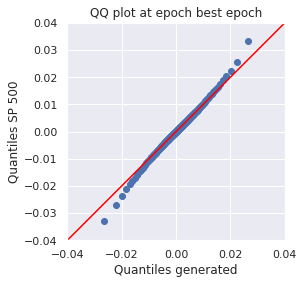

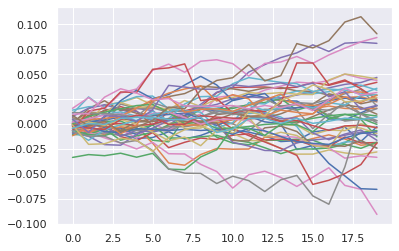

[[0.]]
(1, 1, 1601)
[[[6.84150402e-01 1.48875204e-03 2.93958156e-02 4.96601466e-04]]]
Calculated metrics:  [[0.16593085 0.00036108 0.00712953 0.0004966 ]] pm [[nan nan nan nan]]
metrics:  0.0004949272267637651 0.16117475656086658 0.0012930983430003552 0.008999075819372307
(15000, 20)
[0.08068981 0.1280715  0.10925356 0.08065719 0.06138484 0.0393086
 0.03305271 0.02090838 0.01113171 0.00717576 0.00647485 0.01262784
 0.02162547 0.04479479 0.05426015 0.1006136  0.07840446] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


/home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


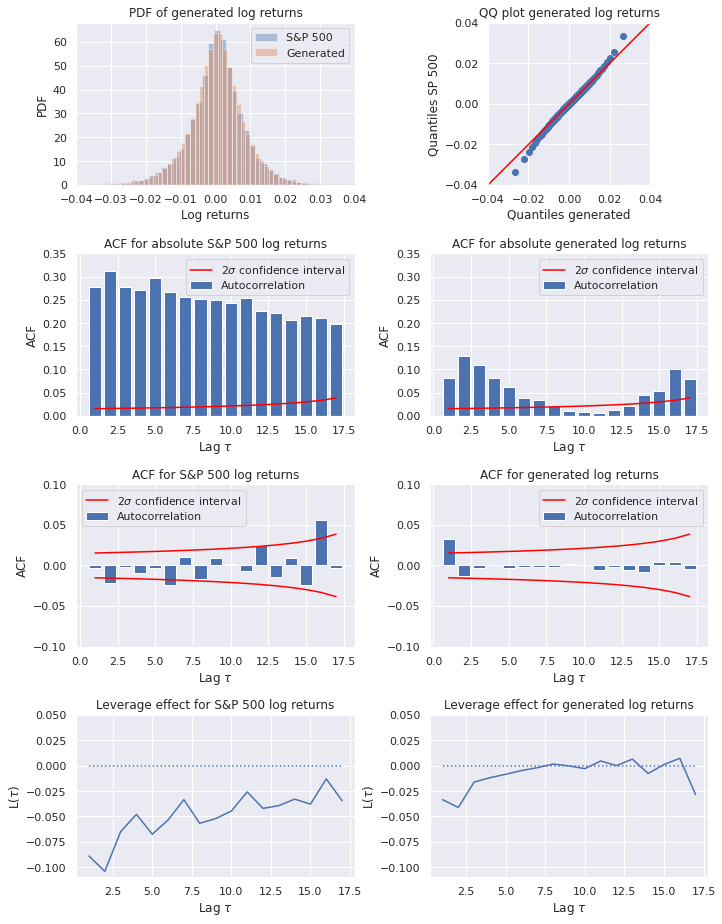

(1, 1601)
(1, 1601)


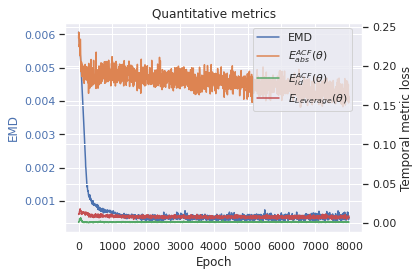

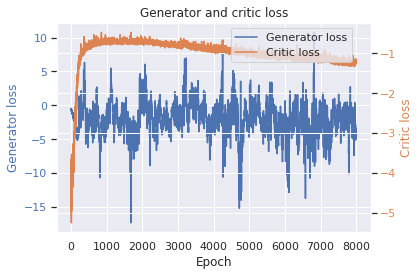

In [3]:
#sweep_qubits(10, 10, 1)
#sweep_qubits_20220120_223257
process_results_layers('sweep_qubits_20220120_223257')

In [4]:
#a = quantum_GAN(8, 5, 8, 4, 6000)
#print(a.generate_observables())
#print(len(a.generate_observables()))
#print(a.benchmarks)

In [5]:
a = quantum_GAN(21, 5, 8, 4, 4000, save = False)

ValueError: in user code:

    /home/schwander/quantum_temporal_gpu/models.py:111 call  *
        return tf.math.multiply(inputs, tf.transpose(self.w))
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:6249 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/schwander/.conda/envs/tfq_env3/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 16 and 21 for '{{node observables-policy/alternating_1/Mul}} = Mul[T=DT_FLOAT](Placeholder, observables-policy/alternating_1/transpose)' with input shapes: [?,16], [1,21].


In [ ]:

ts1 = dh.chopchop(a.log_returns_sp500, 55, 5)
ts2 = a.log_returns_sp500
st.auto_corr(ts1, max_lag = 50, first = False, double_conf = True, double_count = 10)
st.auto_corr(ts2, max_lag = 50, first = False, double_conf = True)

In [ ]:
import pandas as pd

x = pd.plotting.autocorrelation_plot(ts1)
x.plot()
plt.xlim(0,18)
plt.ylim(-0.04,0.04)









































In [ ]:
\